# Classifying the MNIST Digits


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch01_DNN_classification/ec01_A_mnist/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

This notebook provides you with a complete code example that loads the MNIST digits, trains a fully connected neural network with two hidden layers to classify them, and analyzes where the trained network fails.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 1-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Importing the Data

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

> train/0_000000.png<br>
> train/0_000001.png<br>
> ...<br>
> train/1_000000.png<br>
> ...<br>

> test/0_000000.png<br>
> ...<br>
> test/1_000000.png<br>
> ...<br>

The first digit in the filename is the label.

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
train_image_files = sorted(os.listdir(train_path))

Cloning into 'MNIST_dataset'...
Updating files: 100% (70003/70003), done.


Verify that the numebr of training MNIST digits is 60,000 ...

In [2]:
print(len(train_image_files))

60000


... load the digit images in memory ...

In [3]:
import matplotlib.pyplot as plt

train_images = []
for file in train_image_files:
    image = plt.imread(os.path.join(train_path, file))
    train_images.append(image)

... verify the number of loaded digits and the size of the images ...

In [4]:
print(len(train_images))
print(train_images[0].shape)

60000
(28, 28)


... extract the ground thruth digits ...

In [5]:
train_digits = []
for file in train_image_files:
    filename = os.path.basename(file)
    digit = int(filename[0])
    train_digits.append(digit)

... and verify their number.

In [6]:
print(len(train_digits))

60000


## Visualizing the Data

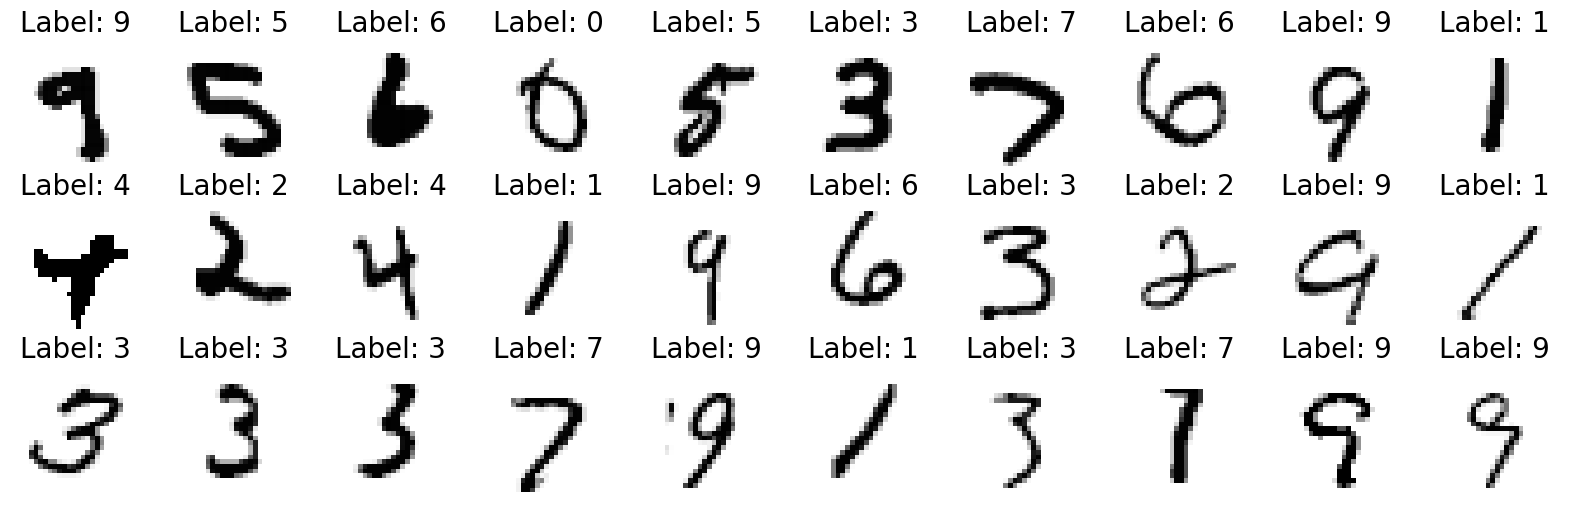

In [7]:
import numpy as np

fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
for ax in axs.ravel():
    idx_image = np.random.choice(60000)
    ax.imshow(train_images[idx_image], cmap="Greys")
    ax.set_title(f"Label: {train_digits[idx_image]}", fontsize=20)
    ax.axis("off")
plt.show()

## Implementing the Neural Network

Define a dense neural network ...

In [8]:
import deeplay as dl
from torch.nn import Sigmoid

mlp_template = dl.MultiLayerPerceptron(
    in_features=28 * 28, hidden_features=[32, 32], out_features=10,
)
mlp_template[..., "activation"].configure(Sigmoid)
mlp_model = mlp_template.create()

... print a summary of the model ...

In [9]:
print(mlp_model)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (activation): Sigmoid()
    )
    (1): LinearBlock(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (activation): Sigmoid()
    )
    (2): LinearBlock(
      (layer): Linear(in_features=32, out_features=10, bias=True)
      (activation): Sigmoid()
    )
  )
)


... print the number of trainable parameters ...

In [10]:
print(f"{sum(p.numel() for p in mlp_model.parameters())} trainable parameters")

26506 trainable parameters


... compile it ...

In [11]:
from torch.nn import MSELoss

classifier_template = dl.Classifier(
    model=mlp_template, num_classes=10, make_targets_one_hot=True,
    loss=MSELoss(), optimizer=dl.SGD(lr=0.1),
)
classifier = classifier_template.create()

... print a summary of the classifier ...

In [12]:
print(classifier)

Classifier(
  (loss): MSELoss()
  (optimizer): SGD[SGD](lr=0.1)
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (activation): Sigmoid()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): Sigmoid()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=32, out_features=10, bias=True)
        (activation): Sigmoid()
      )
    )
  )
)


... and train it.

In [13]:
train_images_digits = list(zip(train_images, train_digits))
train_dataloader = dl.DataLoader(train_images_digits, shuffle=True)

trainer = dl.Trainer(max_epochs=1, accelerator="auto")

trainer.fit(classifier, train_dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss              │      0 │ train │
│ 1 │ train_metrics │ MetricCollection     │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection     │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection     │      0 │ train │
│ 4 │ model         │ MultiLayerPerceptron │ 26.5 K │ train │
│ 5 │ optimizer     │ SGD                  │      0 │ train │
└───┴───────────────┴──────────────────────┴────────┴───────┘

Trainable params: 26.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


### Calculating the Classification Accuracy

Load the test data ...

In [14]:
test_path = os.path.join("MNIST_dataset", "mnist", "test")
test_images_files = sorted(os.listdir(test_path))

test_images, test_digits = [], []
for file in test_images_files:
    image = plt.imread(os.path.join(test_path, file))
    test_images.append(image)

    filename = os.path.basename(file)
    digit = int(filename[0])
    test_digits.append(digit)

test_images_digits = list(zip(test_images, test_digits))
test_dataloader = dl.DataLoader(test_images_digits, shuffle=False)

... and test the performance of the network using them.

In [15]:
trainer.test(classifier, test_dataloader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.6565999984741211      │
│       test_loss_epoch        │     0.05159172788262367      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.05159172788262367,
  'testMulticlassAccuracy_epoch': 0.6565999984741211}]

### Using the Confusion Matrix to Visualize the Neural Network Performance

A _confusion matrix_ illustrates the performance of a classifier and to gain insights to improve its architecture and training hyperparameters. 

A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem (here, 10). Each row and each column corresponds to one class, ordered arbitrarily but equally for the two axes (here, we have a natural ordering of the classes, which is the order of the digits). An element $c_{i,j}$ of the confusion matrix represents the number of times the classifier assigned the predicted class $j$ to the actual class $i$. For example, in our case, $c_{3,5}$ corresponds to the number of times the neural network, when given an image depicting the digit $3$, classifies it as the digit $5$.

In [16]:
from seaborn import cubehelix_palette, heatmap

def plot_confusion_matrix(classifier, dataloader):
    """Plot confusion matrix."""
    confusion_matrix = np.zeros((10, 10), dtype=int)
    for image, gt_digit in dataloader:
        predictions = classifier(image)
        max_prediction, pred_digit = predictions.max(dim=1)
        np.add.at(confusion_matrix, (gt_digit, pred_digit), 1)

    plt.figure(figsize=(10, 8))
    heatmap(confusion_matrix, annot=True, fmt=".0f", square=True,
            cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax=150)
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    plt.show()

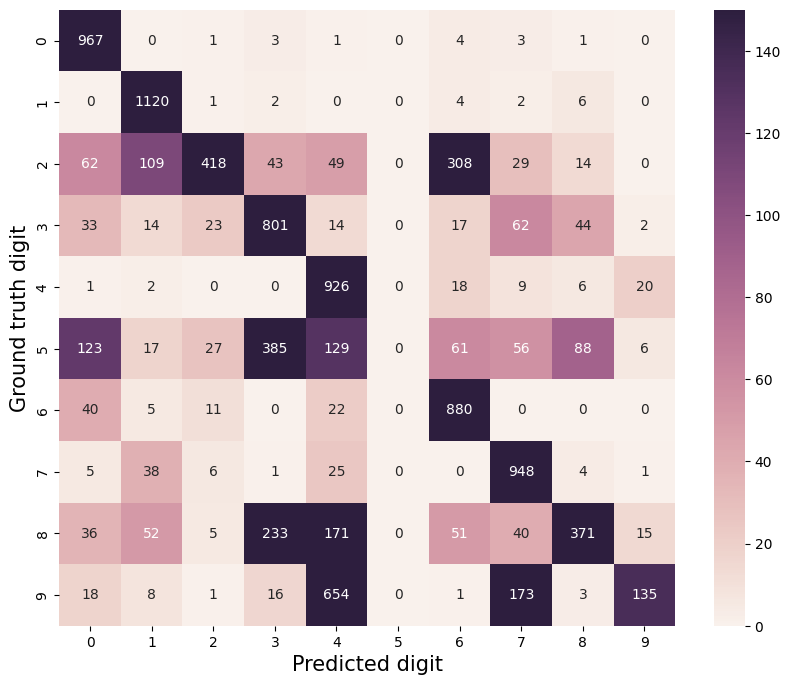

In [17]:
plot_confusion_matrix(classifier, test_dataloader)

## Improving the Neural Network

### Changing Output Representation and Loss Function

Use crossentropy loss.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss              │      0 │ train │
│ 1 │ train_metrics │ MetricCollection     │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection     │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection     │      0 │ train │
│ 4 │ model         │ MultiLayerPerceptron │ 26.5 K │ train │
│ 5 │ optimizer     │ SGD                  │      0 │ train │
└───┴───────────────┴──────────────────────┴────────┴───────┘

Trainable params: 26.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.7318000197410583      │
│       test_loss_epoch        │     0.04333927482366562      │
└──────────────────────────────┴──────────────────────────────┘

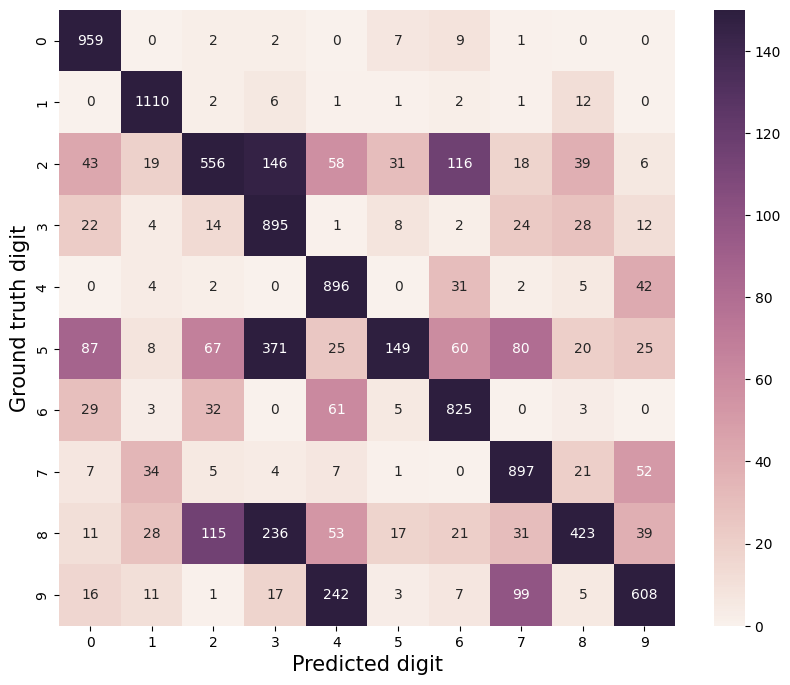

In [18]:
from torch.nn import Softmax

classifier_template[..., "activation#-1"].configure(Softmax, dim=-1)
classifier_softmax = classifier_template.create()

trainer_softmax = dl.Trainer(max_epochs=1, accelerator="auto")
trainer_softmax.fit(classifier_softmax, train_dataloader)

trainer_softmax.test(classifier_softmax, test_dataloader)

plot_confusion_matrix(classifier_softmax, test_dataloader)

### Changing the Activation Functions

Change the activation funtions of the neurons to ReLU.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss              │      0 │ train │
│ 1 │ train_metrics │ MetricCollection     │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection     │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection     │      0 │ train │
│ 4 │ model         │ MultiLayerPerceptron │ 26.5 K │ train │
│ 5 │ optimizer     │ SGD                  │      0 │ train │
└───┴───────────────┴──────────────────────┴────────┴───────┘

Trainable params: 26.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9453999996185303      │
│       test_loss_epoch        │     0.008311033248901367     │
└──────────────────────────────┴──────────────────────────────┘

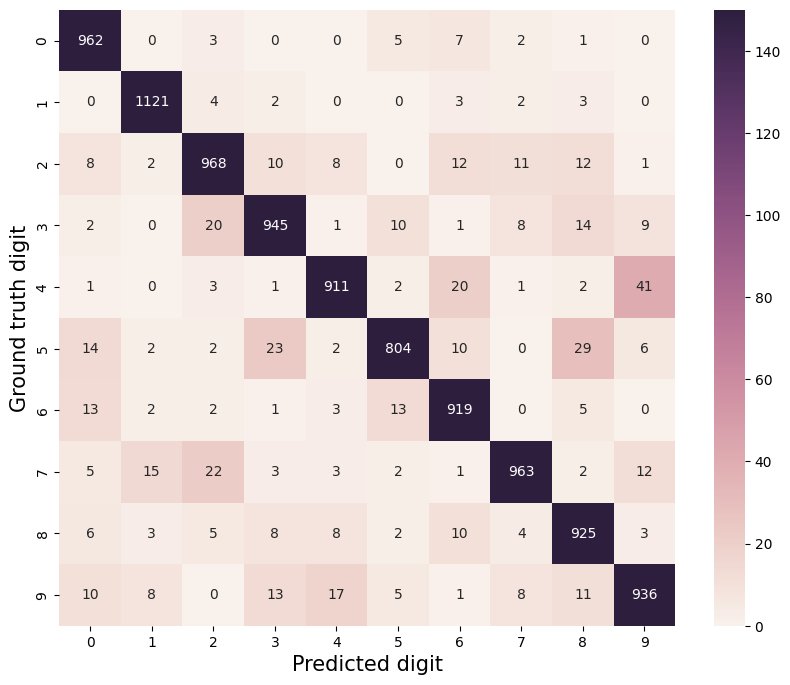

In [19]:
from torch.nn import ReLU

classifier_template[..., "activation#:-1"].configure(ReLU)
classifier_relu = classifier_template.create()

trainer_relu = dl.Trainer(max_epochs=1, accelerator="auto")
trainer_relu.fit(classifier_relu, train_dataloader)

trainer_relu.test(classifier_relu, test_dataloader)

plot_confusion_matrix(classifier_relu, test_dataloader)

### Introducing Mini Batches and Changing the Optimizer

Increase the batch size ...

In [20]:
train_dataloader_batch = dl.DataLoader(train_images_digits, shuffle=True,
                                       batch_size=32)

... and change the optimizer and increase the number of epochs.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss              │      0 │ train │
│ 1 │ train_metrics │ MetricCollection     │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection     │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection     │      0 │ train │
│ 4 │ model         │ MultiLayerPerceptron │ 26.5 K │ train │
│ 5 │ optimizer     │ RMSprop              │      0 │ train │
└───┴───────────────┴──────────────────────┴────────┴───────┘

Trainable params: 26.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 19                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9685999751091003      │
│       test_loss_epoch        │     0.004895704332739115     │
└──────────────────────────────┴──────────────────────────────┘

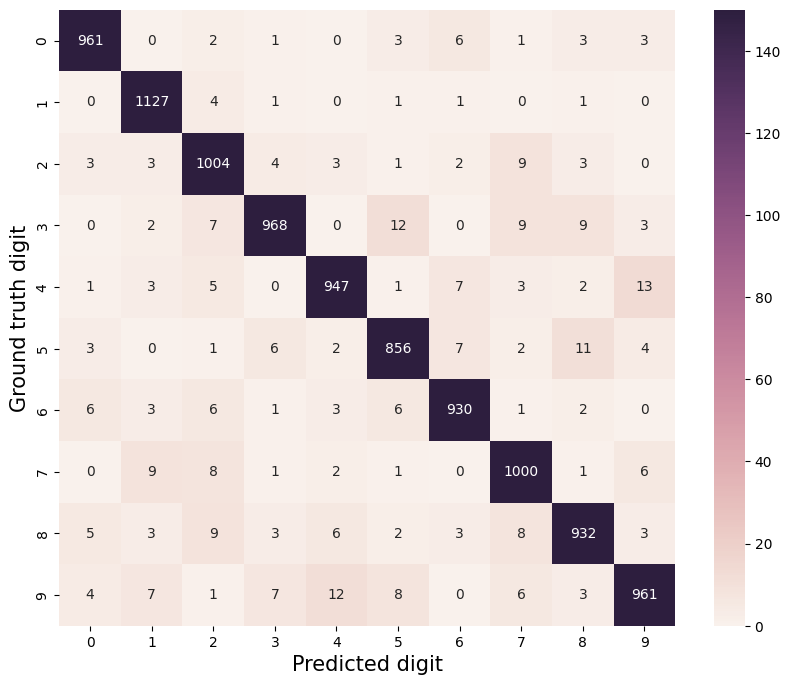

In [21]:
classifier_template.configure(optimizer=dl.RMSprop(lr=0.001))
classifier_rmsprop = classifier_template.create()

trainer_rmsprop = dl.Trainer(max_epochs=10, accelerator="auto")
trainer_rmsprop.fit(classifier_rmsprop, train_dataloader_batch)

trainer_rmsprop.test(classifier_rmsprop, test_dataloader)

plot_confusion_matrix(classifier_rmsprop, test_dataloader)

## Performing a Failure Analysis

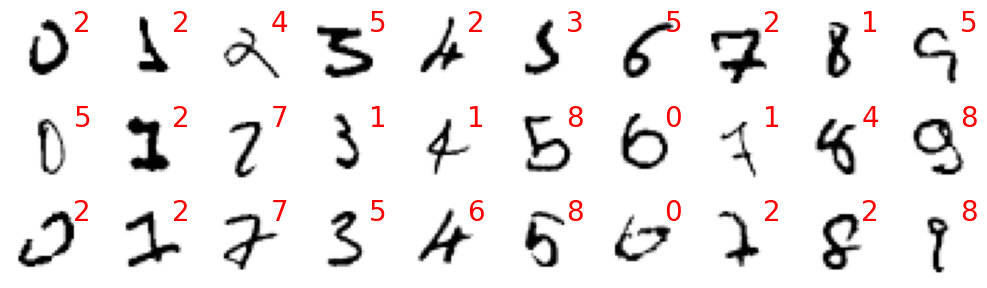

In [22]:
num_images_x_digit = 3

plt.figure(figsize=(10, num_images_x_digit))

num_fails_x_digit = np.zeros(10, int)
for image, gt_digit in test_dataloader:
    gt_digit = int(gt_digit)

    if num_fails_x_digit[gt_digit] < num_images_x_digit:
        predictions = classifier_rmsprop(image)
        max_prediction, pred_digit = predictions.max(dim=1)

        if pred_digit != gt_digit:
            num_fails_x_digit[gt_digit] += 1

            plt.subplot(num_images_x_digit, 10,
                        (num_fails_x_digit[gt_digit] - 1) * 10 + gt_digit + 1)
            plt.imshow(image.squeeze(), cmap="Greys")
            plt.annotate(str(int(pred_digit)), (.8, 1), (1, 1),
                         xycoords="axes fraction", textcoords="offset points",
                         va="top", ha="left", fontsize=20, color="red")
            plt.axis("off")

    if (num_fails_x_digit >= num_images_x_digit).all():
        break

plt.tight_layout()
plt.show()